# Task 2 Mainly ML
By Avikal Singh

In [71]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping
from transformers import BertTokenizer, TFBertForSequenceClassification


### Data Loading 
Observing the contents of the dataset

In [72]:
np.random.seed(42) # Using Seed to reproduce same output everytime.
tf.random.set_seed(42)
data = pd.read_csv("Problem_Dataset.csv") # Reading the data file
data.head() 

,sID,Obs,Type,A1,A2,A3,B1,B2,B3,B4
0,150668,Observed child fixated on a particular texture...,B3,0,0,0,0,0,1,0
1,150409,"Patient's focus centers on vacuum cleaners, st...",B3,0,0,0,0,0,1,0
2,150264,Displays a strong interest in smelling various...,B4,0,0,0,0,0,0,1
3,150373,Patient's attachment to a specific book is evi...,B3,0,0,0,0,0,1,0
4,150343,"Limited awareness of personal boundaries, inva...",A3,0,0,1,0,0,0,0


Analyzing the word count for each "Obs" column <br>
We can see average words are approximately 13 and maximum words are 26

In [73]:
data['Obs'].apply(lambda x: len(x.split())).describe()

count    1050.000000
mean       13.636190
std         3.546911
min         6.000000
25%        11.000000
50%        14.000000
75%        16.000000
max        26.000000
Name: Obs, dtype: float64

Checking the data if any null values or missing data exists.<br>
Luckily, no missing values!!

In [74]:
data.info()
data.isnull().describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sID     1050 non-null   int64 
 1   Obs     1050 non-null   object
 2   Type    1050 non-null   object
 3   A1      1050 non-null   int64 
 4   A2      1050 non-null   int64 
 5   A3      1050 non-null   int64 
 6   B1      1050 non-null   int64 
 7   B2      1050 non-null   int64 
 8   B3      1050 non-null   int64 
 9   B4      1050 non-null   int64 
dtypes: int64(8), object(2)
memory usage: 82.2+ KB


,sID,Obs,Type,A1,A2,A3,B1,B2,B3,B4
count,1050,1050,1050,1050,1050,1050,1050,1050,1050,1050
unique,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False
freq,1050,1050,1050,1050,1050,1050,1050,1050,1050,1050


### Data Cleaning and Preprocessing 
**Tokenizing the data**
 - Taking max sequence length of 25 because the longest line has 26 words.
 - Adding padding at the end of words 

In [75]:
def clean_and_prepare_data(data, max_vocab_size=5000, max_length=25):
    # Tokenizing the text 
    tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<OOV>') # Out of vocabulary words replaced by <OOV> tag and max vocab words are 5000.
    tokenizer.fit_on_texts(data['Obs'])
    sequences = tokenizer.texts_to_sequences(data['Obs']) # creating sequences of 25 words each 
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post') # padding at end of leftover spaces with 0.
    
    return padded_sequences, tokenizer

## Subtask 1: Ensemble Model
 1. Using **LSTM Model** as a deep learning model to learn the sequence and assign the label to each
 2. LSTM Model 
    - LSTM layer -> 64 nodes
    - Dropout layer (50% drop rate)
    - LSTM layer -> 64 nodes 
    - Dense layer -> 64 nodes | activation function: Relu
    - Dropout layer (50% drop rate)
    - Last layer -> activation function: Sigmoid (returns binary value)

In [76]:
# Model building function
def build_lstm_model(input_dim, output_dim=1, input_length=25):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=64, input_length=input_length),
        
        # Added a LSTM layer with 64 nodes, which processes sequences and returns only the last output
        LSTM(64, return_sequences=False),
        
        # Added a Dropout layer to prevent overfitting 
        Dropout(0.5),

        # Add a Dense layer with 64 units and ReLU activation function
        Dense(64, activation='relu'),
        Dropout(0.5),

        # Added a last layer with sigmoid activation function for binary classification
        Dense(output_dim, activation='sigmoid')
    ])
    
    # Compile the model with 
    # binary cross-entropy as loss, 
    # Adam optimizer as optimizer, 
    # accuracy metric to monitor the training process 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### Model Training 
 - Training and saving models for all 7 labels
 - 10 Epochs
 - Train:Test Split = 80:20


In [77]:
# Model training function
def train_and_save_models(data, labels, tokenizer, label_names, max_length=25, epochs=10, batch_size=32):
    for label in label_names:
        # Splitting data for the current label
        X_train, X_val, y_train, y_val = train_test_split(data, labels[label], test_size=0.2, random_state=42)
        
        # Building the model
        model = build_lstm_model(input_dim=len(tokenizer.word_index) + 1, input_length=max_length)
        
        # Training the model
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
        
        # Saving the model
        model.save(f'{label}_model.h5')
        print(f"Model for {label} saved.")

In [78]:
padded_sequences, tokenizer = clean_and_prepare_data(data)
labels = data[['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'B4']]

# Running for 10 epochs
train_and_save_models(padded_sequences, labels, tokenizer, labels.columns)


Epoch 1/10
27/27 [==============================] - 2s 23ms/step - loss: 0.5268 - accuracy: 0.8452 - val_loss: 0.3995 - val_accuracy: 0.8619
Epoch 2/10
27/27 [==============================] - 0s 13ms/step - loss: 0.4347 - accuracy: 0.8560 - val_loss: 0.3668 - val_accuracy: 0.8619
Epoch 3/10
27/27 [==============================] - 0s 13ms/step - loss: 0.2913 - accuracy: 0.8726 - val_loss: 0.2444 - val_accuracy: 0.9048
Epoch 4/10
27/27 [==============================] - 0s 14ms/step - loss: 0.1907 - accuracy: 0.9405 - val_loss: 0.2739 - val_accuracy: 0.8952
Epoch 5/10
27/27 [==============================] - 0s 14ms/step - loss: 0.1491 - accuracy: 0.9440 - val_loss: 0.2805 - val_accuracy: 0.9190
Epoch 6/10
27/27 [==============================] - 0s 14ms/step - loss: 0.1057 - accuracy: 0.9750 - val_loss: 0.3160 - val_accuracy: 0.9048
Epoch 7/10
27/27 [==============================] - 0s 14ms/step - loss: 0.1417 - accuracy: 0.9571 - val_loss: 0.3304 - val_accuracy: 0.9095
Epoch 8/10
27

### Evaluation Time!! 
**Evaluation Metrics**
 - Precision
 - Recall 
 - F1 Score

In [79]:
# Load all models
def load_and_predict(models, tokenizer, texts, max_length=25):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
    
    # Looping through all 7 models
    predictions = []
    for model_name in models:
        model = load_model(model_name)
        # predicting and converting the probabilities into binary (0 or 1)
        prediction = (model.predict(padded_sequences) > 0.5).astype(int)
        predictions.append(prediction)
        
    return np.hstack(predictions)

# Evaluating the ensemble predictions
def evaluate_models(models, tokenizer, data, labels, label_names, max_length=25):
    predictions = load_and_predict(models, tokenizer, data['Obs'], max_length)
    results = {}

    # Looping through each label to calculate precision, recall, and F1-score 
    for i, label in enumerate(label_names):
        precision, recall, f1, _ = precision_recall_fscore_support(labels[label], predictions[:, i], average='binary')
        results[label] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
    
    return results

# Define model paths
model_names = [f'{label}_model.h5' for label in labels.columns]

# Evaluate models
results = evaluate_models(model_names, tokenizer, data, labels, labels.columns)
print(results)

# Save results
results_df = pd.DataFrame(results).transpose()
results_df.to_csv('subtask1_model_evaluation_results.csv', index=True)


33/33 [==============================] - 0s 4ms/step
{'A1': {'precision': 0.9507042253521126, 'recall': 0.9, 'f1_score': 0.9246575342465754}, 'A2': {'precision': 0.9523809523809523, 'recall': 0.9333333333333333, 'f1_score': 0.9427609427609428}, 'A3': {'precision': 0.8875, 'recall': 0.9466666666666667, 'f1_score': 0.9161290322580645}, 'B1': {'precision': 0.9795918367346939, 'recall': 0.96, 'f1_score': 0.9696969696969697}, 'B2': {'precision': 0.9539473684210527, 'recall': 0.9666666666666667, 'f1_score': 0.9602649006622517}, 'B3': {'precision': 0.9664429530201343, 'recall': 0.96, 'f1_score': 0.9632107023411371}, 'B4': {'precision': 0.9493670886075949, 'recall': 1.0, 'f1_score': 0.974025974025974}}


## Subtask 2: Multi-label Model
 1. Using **LSTM Model** as a deep learning model to learn the sequence and assign the label to each
 2. LSTM Model with 7 outputs(labels)
    - LSTM layer -> 64 nodes
    - Dense layer -> 64 nodes | activation function: Relu
    - Last layer -> activation function: Sigmoid (returns binary value)

In [80]:
# Model building function
def build_multilabel_model(input_dim, output_dim=7, input_length=25):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=64, input_length=input_length),
        LSTM(64, return_sequences=False),
        # Dropout(0.5), removing dropout to avoid randomness as it harmed the predictions
        Dense(64, activation='relu'),
        # Dropout(0.5),
        Dense(output_dim, activation='sigmoid')  # Multiple outputs for multi-label classification
    ])
    
    # Compile the model with 
    # binary cross-entropy as loss, 
    # Adam optimizer as optimizer with learning rate as 0.001, 
    # accuracy metric to monitor the training process
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

### Model Training 
 - Training and saving model
 - 40 Epochs as there are 7 labels all together.
 - Train:Test = 80:20


In [81]:
# Model training function
def train_and_save_multilabel_model(data, labels, tokenizer, max_length=25, epochs=40, batch_size=32):
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(data, labels, train_size=0.8, test_size=0.2, random_state=42)
    
    # Build the model
    model = build_multilabel_model(input_dim=len(tokenizer.word_index) + 1, input_length=max_length)

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), shuffle = False)
    
    # Save the model
    model.save('multilabel_model.h5')
    print("Multi-label model saved.")


Running 40 epochs 

In [82]:
# Train and save the multi-label model
train_and_save_multilabel_model(padded_sequences, labels, tokenizer)

Epoch 1/40
27/27 [==============================] - 2s 22ms/step - loss: 0.5548 - accuracy: 0.1262 - val_loss: 0.4198 - val_accuracy: 0.1286
Epoch 2/40
27/27 [==============================] - 0s 13ms/step - loss: 0.4133 - accuracy: 0.1274 - val_loss: 0.4108 - val_accuracy: 0.1714
Epoch 3/40
27/27 [==============================] - 0s 13ms/step - loss: 0.4119 - accuracy: 0.1345 - val_loss: 0.4121 - val_accuracy: 0.1286
Epoch 4/40
27/27 [==============================] - 0s 13ms/step - loss: 0.4116 - accuracy: 0.1321 - val_loss: 0.4119 - val_accuracy: 0.1286
Epoch 5/40
27/27 [==============================] - 0s 14ms/step - loss: 0.4115 - accuracy: 0.1321 - val_loss: 0.4118 - val_accuracy: 0.1286
Epoch 6/40
27/27 [==============================] - 0s 14ms/step - loss: 0.4115 - accuracy: 0.1321 - val_loss: 0.4117 - val_accuracy: 0.1286
Epoch 7/40
27/27 [==============================] - 0s 14ms/step - loss: 0.4115 - accuracy: 0.1310 - val_loss: 0.4118 - val_accuracy: 0.1286
Epoch 8/40
27

### Load the multi-label model and predict

In [83]:
def load_and_predict_multilabel_model(model_path, tokenizer, texts, max_length=25):
    model = load_model(model_path)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
    predictions = (model.predict(padded_sequences) > 0.5).astype(int)
    return predictions

### Time to see reults !!!

In [84]:
# Evaluate the model's performance
def evaluate_multilabel_model(model_path, tokenizer, data, labels, label_names, max_length=25):
    predictions = load_and_predict_multilabel_model(model_path, tokenizer, data['Obs'], max_length)
    results = {}

    # Loop through each label to calculate precision, recall, and F1-score
    for i, label in enumerate(label_names):
        precision, recall, f1, _ = precision_recall_fscore_support(labels[label], predictions[:, i], average='binary')
        # Store the results for the current label in the dictionary
        results[label] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
    
    return results


Saving the data

In [85]:
# Define model path
model_path = 'multilabel_model.h5'

# Evaluate the model
results = evaluate_multilabel_model(model_path, tokenizer, data, labels, labels.columns)
print(results)

# Save results
results_df = pd.DataFrame(results).transpose()
results_df.to_csv('multilabel_model_evaluation_results.csv', index=True)

33/33 [==============================] - 0s 4ms/step
{'A1': {'precision': 0.8543046357615894, 'recall': 0.86, 'f1_score': 0.8571428571428571}, 'A2': {'precision': 0.9758064516129032, 'recall': 0.8066666666666666, 'f1_score': 0.8832116788321168}, 'A3': {'precision': 0.8023952095808383, 'recall': 0.8933333333333333, 'f1_score': 0.8454258675078864}, 'B1': {'precision': 0.9785714285714285, 'recall': 0.9133333333333333, 'f1_score': 0.9448275862068966}, 'B2': {'precision': 0.9662162162162162, 'recall': 0.9533333333333334, 'f1_score': 0.959731543624161}, 'B3': {'precision': 0.9333333333333333, 'recall': 0.9333333333333333, 'f1_score': 0.9333333333333333}, 'B4': {'precision': 0.9197530864197531, 'recall': 0.9933333333333333, 'f1_score': 0.9551282051282052}}


## Subtask 3: BERT Model

In [96]:
# Initializing tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(texts):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=25, return_tensors='tf')

# Preparing the data
labels = data[['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'B4']]
tokenized_data = tokenize_function(data['Obs'].tolist())


c:\Users\avika\anaconda3\envs\DeepTarget2\lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Splitting and Preparing TensorFlow Datasets

In [97]:
# Ensure input_ids and attention_mask are NumPy arrays
input_ids = np.array(tokenized_data['input_ids'])
attention_mask = np.array(tokenized_data['attention_mask'])

# Split the tokenized data (input_ids and attention_mask) and labels
train_ids, test_ids, train_mask, test_mask = train_test_split(
    input_ids, attention_mask, test_size=0.2, random_state=42
)

# Split the labels separately
train_labels, test_labels = train_test_split(labels, test_size=0.2, random_state=42)

# Create TensorFlow datasets
def create_tf_dataset(input_ids, attention_mask, labels):
    inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels.values))
    dataset = dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_tf_dataset(train_ids, train_mask, train_labels)
test_dataset = create_tf_dataset(test_ids, test_mask, test_labels)

Honestly, I tried to use GPU for faster computation but it didn't go well and caused version mismatch between many libraries. <br> So, I dropped the idea and now it can take around 20-30 mins to execute.  

In [95]:
# Check if TensorFlow is using GPU
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

### Fine-Tuning BERT Model
 - 20 Epochs
 - Loss: Binary Crossentropy 

In [89]:
# Load pre-trained BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=7, problem_type="multi_label_classification")

# Compile model using the standard TensorFlow optimizer
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),  # Standard Adam optimizer
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train model with class weights
with tf.device('/GPU:0'):  # Sadly, it is just an extra useless line for now.
    model.fit(train_dataset, epochs=20, validation_data=test_dataset)


c:\Users\avika\anaconda3\envs\DeepTarget2\lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20
27/27 [==============================] - 102s 3s/step - loss: 1.3198 - accuracy: 0.1702 - val_loss: 1.1070 - val_accuracy: 0.2667
Epoch 2/20
27/27 [==============================] - 85s 3s/step - loss: 0.9513 - accuracy: 0.2917 - val_loss: 0.6491 - val_accuracy: 0.2810
Epoch 3/20
27/27 [==============================] - 87s 3s/step - loss: 0.8683 - accuracy: 0.2190 - val_loss: 0.9510 - val_accuracy: 0.1429
Epoch 4/20
27/27 [==============================] - 84s 3s/step - loss: 0.7384 - accuracy: 0.2833 - val_loss: 0.6261 - val_accuracy: 0.4286
Epoch 5/20
27/27 [==============================] - 84s 3s/step - loss: 0.6600 - accuracy: 0.3643 - val_loss: 0.5908 - val_accuracy: 0.5333
Epoch 6/20
27/27 [==============================] - 85s 3s/step - loss: 0.6096 - accuracy: 0.4333 - val_loss: 0.5802 - val_accuracy: 0.5381
Epoch 7/20
27/27 [==============================] - 84s 3s/step - loss: 0.6520 - accuracy: 0.3619 - val_loss: 0.6257 - val_accuracy: 0.4190
Epoch 8/20
27/27 [=

Accuracy seems fine!!!

### Evaluating BERT Model Performance on Test Data

In [90]:
# Evaluate model
predictions = model.predict(test_dataset)
y_pred = np.round(tf.nn.sigmoid(predictions.logits).numpy())  # Sigmoid to convert logits to probabilities

y_true = test_labels.values

# Calculate precision, recall, F1-score for each label
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

# Calculate accuracy (optional)
accuracy = accuracy_score(y_true, y_pred)

# Print metrics for each label
metrics = {
    '': test_labels.columns,
    'precision': precision,
    'recall': recall,
    'f1_score': f1_score
}
metrics_df = pd.DataFrame(metrics)

# Save metrics to CSV
metrics_df.to_csv('metrics_per_label.csv', index=False)

# Print metrics for verification
print(metrics_df)
print(f'Overall Accuracy: {accuracy:.4f}')

7/7 [==============================] - 9s 1s/step
       precision    recall  f1_score
0  A1   0.128205  0.344828  0.186916
1  A2   0.107843  0.423077  0.171875
2  A3   0.168539  0.483871  0.250000
3  B1   0.148148  0.228571  0.179775
4  B2   0.115385  0.346154  0.173077
5  B3   0.169014  0.333333  0.224299
6  B4   0.078125  0.185185  0.109890
Overall Accuracy: 0.0286


Results don't seem to be fine.

## Subtask 4: Plotting and Visualizing the Data 

In [91]:
import matplotlib.pyplot as plt

# Load results and assigning one value to each type of result
ensemble_results = pd.read_csv('subtask1_model_evaluation_results.csv', index_col=0)
multilabel_results = pd.read_csv('multilabel_model_evaluation_results.csv', index_col=0)
bert_results = pd.read_csv('metrics_per_label.csv', index_col=0)


### Organizing Model Performance Metrics for Analysis

In [92]:
# Extracting the data
labels = ensemble_results.index.tolist()

# Assigning each metric to a specific variable.
ensemble_precision = ensemble_results['precision'].tolist()
ensemble_recall = ensemble_results['recall'].tolist()
ensemble_f1 = ensemble_results['f1_score'].tolist()

multilabel_precision = multilabel_results['precision'].tolist()
multilabel_recall = multilabel_results['recall'].tolist()
multilabel_f1 = multilabel_results['f1_score'].tolist()

bert_precision = bert_results['precision'].tolist()
bert_recall = bert_results['recall'].tolist()
bert_f1 = bert_results['f1_score'].tolist()


### Label-Wise Comparison of Precision, Recall, and F1 Scores

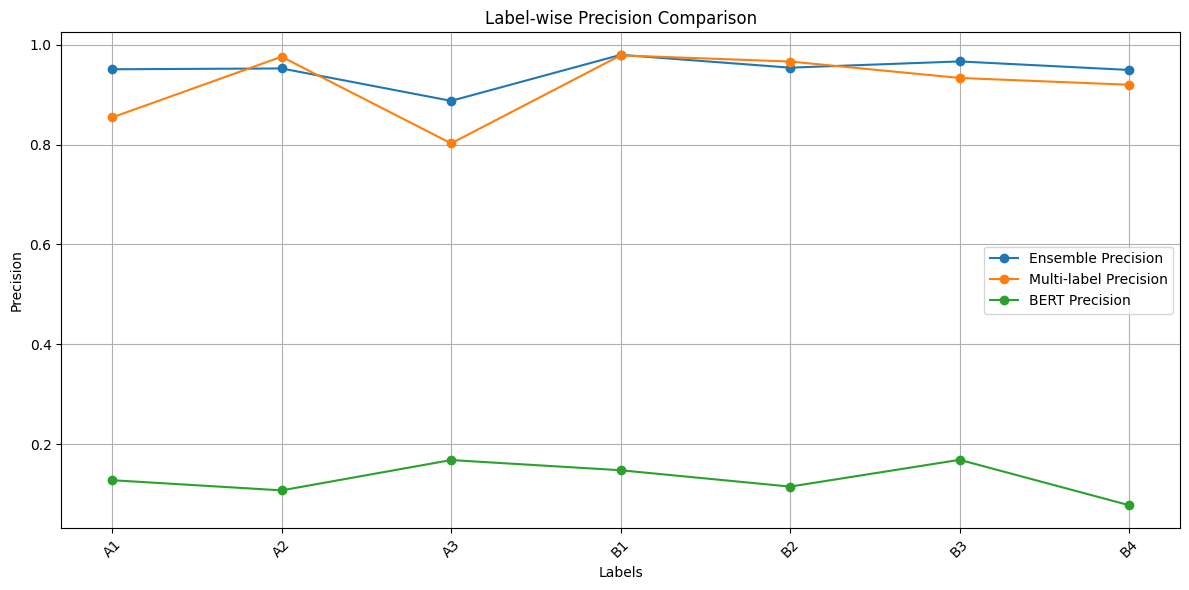

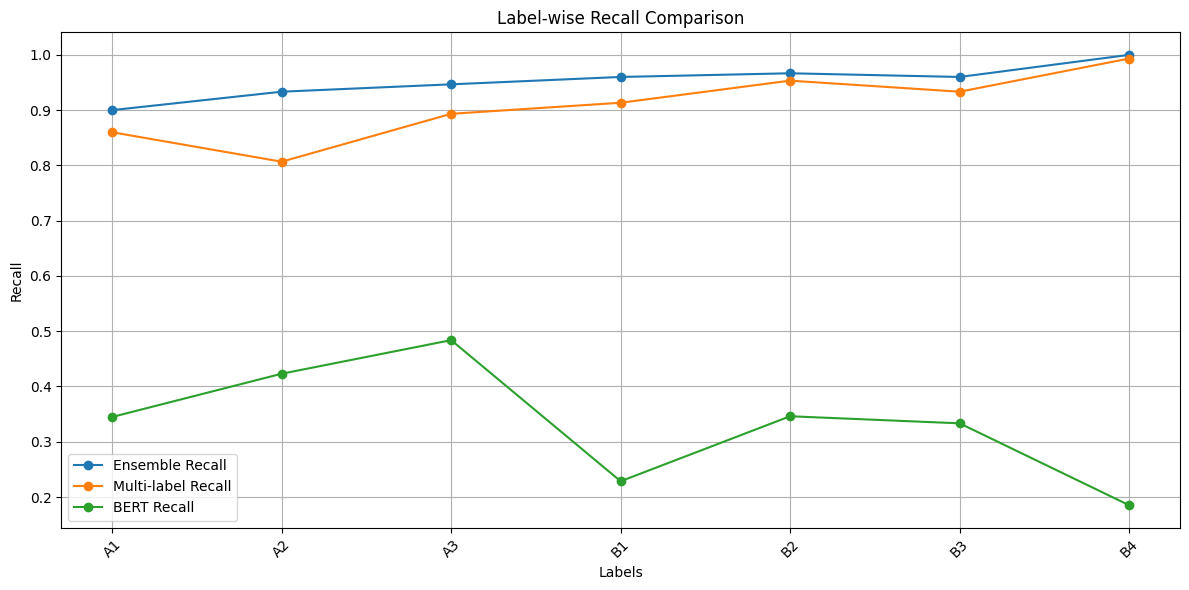

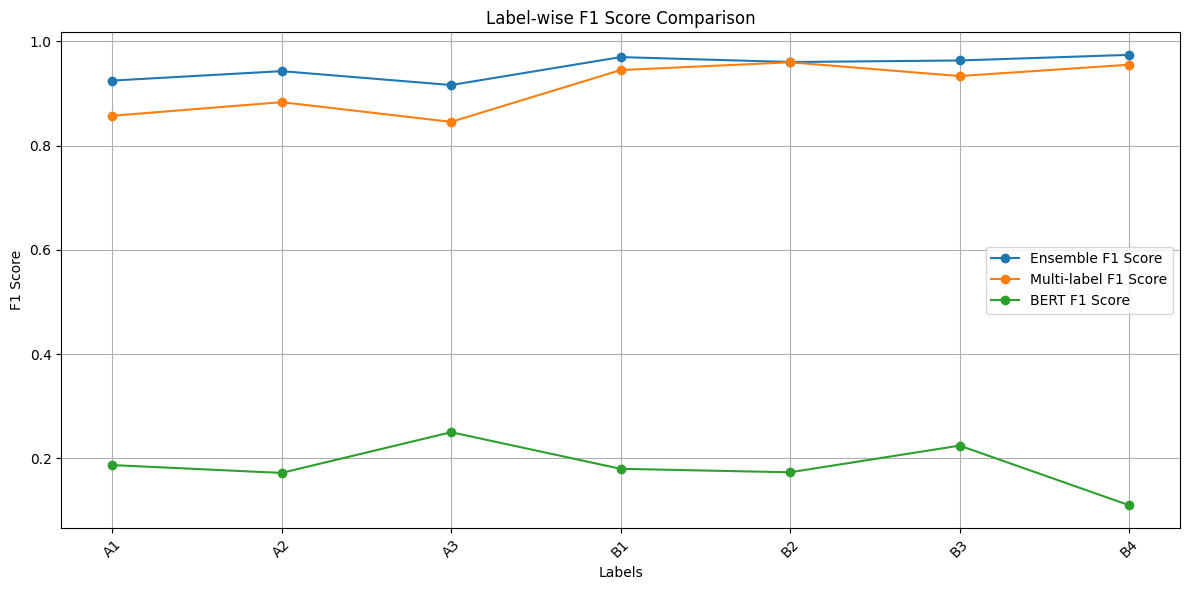

In [93]:
# Plot Precision
plt.figure(figsize=(12, 6))
plt.plot(labels, ensemble_precision, marker='o', label='Ensemble Precision')
plt.plot(labels, multilabel_precision, marker='o', label='Multi-label Precision')
plt.plot(labels, bert_precision, marker='o', label='BERT Precision')
plt.xlabel('Labels')
plt.ylabel('Precision')
plt.title('Label-wise Precision Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('precision_comparison.png')
plt.show()

# Plot Recall
plt.figure(figsize=(12, 6))
plt.plot(labels, ensemble_recall, marker='o', label='Ensemble Recall')
plt.plot(labels, multilabel_recall, marker='o', label='Multi-label Recall')
plt.plot(labels, bert_recall, marker='o', label='BERT Recall')
plt.xlabel('Labels')
plt.ylabel('Recall')
plt.title('Label-wise Recall Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('recall_comparison.png')
plt.show()

# Plot F1 Score
plt.figure(figsize=(12, 6))
plt.plot(labels, ensemble_f1, marker='o', label='Ensemble F1 Score')
plt.plot(labels, multilabel_f1, marker='o', label='Multi-label F1 Score')
plt.plot(labels, bert_f1, marker='o', label='BERT F1 Score')
plt.xlabel('Labels')
plt.ylabel('F1 Score')
plt.title('Label-wise F1 Score Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('f1_score_comparison.png')
plt.show()

## Conclusion
 - Ensemble and Multilabel Models have performed well
 - BERT model did not stood up to the mark, reasons:
    - The performance of BERT could have been affected by how the input data was preprocessed.
    - Tokenization and padding may have impacted BERT's effectiveness
    - May be longer training time could have improved the performance (*reason why I was looking for a GPU access*)